# Data analysis with ibmdbpy and Db2 Warehouse - Part 2: Recommendation

This notebook shows you how to use ibmdbpy to handle geospatial data, with a point of interest recommandation use case.
___

### Accelerate Python analytics with in-database processing by using ibmdbpy and IBM Db2 Warehouse

The ibmdbpy project provides access to in-database algorithms in IBM Db2 Warehouse through a Python interface for data manipulation. It accelerates Python analytics by seamlessly pushing operations written in Python into the underlying database for execution, thereby benefitting from in-database performance-enhancing features, such as columnar storage and parallel processing. For more details about ibmdbpy, please refer to the [documentation](https://pythonhosted.org/ibmdbpy/index.html) and to the dedicated [Git repository](https://github.com/ibmdbanalytics/ibmdbpy/tree/master/ibmdbpy). This notebook provides you with an overview of ibmdbpy functionalities through a tourism use case. 


__About this notebook__

In the "Museums" notebook series, you get deeper insights about how to perform in-database analytics with ibmdbpy.
Our use case: tourism in the United States. Imagine you have designed a tourism app and want to recommand activities or places to users according to their location, taste and some geographic constraints. Ibmdbpy spatial extension enables you to efficiently query your database for real-time recommandation. There are two notebooks: 

1. Open and preprocess data: [Preprocessing notebook](./ibmdbpy_Museums_DataAnalysis_1-preprocessing.ipynb)
2. Recommend a Point of Interest in the US: here you are!


__Prerequisites__
* Db2 account: see [IBM Cloud](https://cloud.ibm.com/login) or [Db2 Warehouse](https://www.ibm.com/support/knowledgecenter/en/SSCJDQ/com.ibm.swg.im.dashdb.kc.doc/welcome.html)
* Db2 driver: learn more on [IBM Knowledge Center](https://www.ibm.com/support/knowledgecenter/en/SSFMBX/com.ibm.swg.im.dashdb.doc/connecting/connect_applications_by_type.html) and see [IBM Support](https://www.ibm.com/support/pages/db2-jdbc-driver-versions-and-downloads)
* Having installed the [ibmdbpy](https://pypi.org/project/ibmdbpy/) python library with pip: 
> pip install ibmdbpy 
* Optional dependency for JDBC is the [jaydebeapi](https://pypi.org/project/JayDeBeApi/) library. Run the following command to install ibmdbpy, as well as the dependencies for the JDBC feature:
> pip install ibmdbpy[jdbc]
* The [museums.csv](https://www.kaggle.com/imls/museum-directory/data) dataset.

Note: the museums dataset we use in this notebook has been published under the licence CC0 1.0 Universal (CC0 1.0) /
Public Domain Dedication (see [source](https://www.kaggle.com/imls/museum-directory/data)).


__Contents__

__1. Get started__
* Imports
* Establish JDBC connection
* Load the data: Museums and Tourists datasets

__2. Point of interest recommendation__

* step 1: filter on category
* step 2: buffer
* visualization

## 1. Get started

As usual, we make the necessary imports and establish a connection to Db2 Warehouse. Then we load the data using ibmdbpy.

__Imports__

Jaydebeapi is used in order to establish a JDBC connection. We load the necessary classes of ibmdbpy. Pandas, numpy, seaborn and matplotlib are used for data visualization.

In [1]:
# connection to Db2, ibmdbpy classes
from ibmdbpy import IdaDataBase, IdaDataFrame, IdaGeoDataFrame

# for visualization and data transformation
import pandas
import geopandas
import numpy as np
from shapely.geometry import Point
import seaborn as sns
import matplotlib.pyplot as plt

__Establish JDBC connection__

The JDBC connection is based on a Java Virtual Machine, so it is available on every machine that can run Java. In ibmdbpy, users can choose to use JDBC to connect to a remote Db2 instance. 

You have to enter your own credentials in the following cell.

In [2]:
#Enter the values for you database connection
dsn_database = "___" # e.g. "BLUDB"
dsn_hostname = "___" # e.g.: "abc.url.example"
dsn_port = "___"    # e.g. "50000"
dsn_uid = "___"     # e.g. "db2_1234"
dsn_pwd = "___"     # e.g. "zorglub"

In [3]:
#Establish connection
connection_string='jdbc:db2://'+dsn_hostname+':'+dsn_port+'/'+dsn_database+':user='+dsn_uid+';password='+dsn_pwd+";" 
idadb=IdaDataBase(dsn=connection_string)

In [4]:
# Define your verbosity settings
from ibmdbpy.utils import set_verbose
set_verbose(False)

The connection is now established! If you leave this notebook open for a while, it might get closed even if your Kernel does not die. No problem! Your variables are not lost, it is only the connection that has been interrupted. Just run the following to reconnect:

> idadb.reconnect()

In the end if this notebook, you will close the connection by running:

> idadb.close()

By default the environment variable `AUTOCOMMIT` is then set to True, which means that every SQL statement which is submitted through the connection is executed within its own transaction and then committed implicitly. When you close the connection to Db2, if the environment variable `AUTOCOMMIT` is set to False, then all changes after the last explicit commit are discarded. 

__Load the data: Museums and Tourists datasets__

Here we directly load the data we have saved to Db2 at the end of the previous notebook. We also create another table containing user information.

* GEO_MUSEUMS table

Note that we specify the geometry column and the index column. 

In [5]:
# Download the dataset from a Db2 instance
geo_museums = IdaGeoDataFrame(idadb, 'GEO_MUSEUMS', geometry = 'GEOM', indexer = 'ID')
geo_museums.head()

/Users/eva.feillet/.local/lib/python3.7/site-packages/jaydebeapi/__init__.py:250: UserWarning: No type mapping for JDBC type 'STRUCT' (constant value 2002). Using None as a default type_code.
  "Using None as a default type_code." % (type_name, jdbc_type_const))


,ID,GEOM,MUSEUMTYPE,MUSEUMNAME
0,8400100001,POINT (-87.505100 33.295310),GENERAL MUSEUM,WESTERVELT-WARNER MUSEUM OF AMERICAN ART
1,8400100002,POINT (-85.719780 31.349360),GENERAL MUSEUM,U. S. ARMY AVIATION MUSEUM
2,8400100004,POINT (-86.628410 34.713800),GENERAL MUSEUM,U.S. SPACE & ROCKET CENTER
3,8400100005,POINT (-85.955410 32.943940),GENERAL MUSEUM,WELLBORN MUSCLECAR MUSEUM
4,8400100007,POINT (-88.044830 30.690950),GENERAL MUSEUM,USS ALABAMA BATTLESHIP


* GEO_TOURISTS table

We show you how to create a sample of user data. We just insert a few user profiles in a new table for this scenario.

In [6]:
def create_tourists():        
    #idadb.ida_query('SET CURRENT FUNCTION PATH = CURRENT FUNCTION PATH, db2gse') 
    idadb.ida_query('CREATE TABLE GEO_TOURISTS(user_id INT GENERATED BY DEFAULT AS IDENTITY NOT NULL, user_loc db2gse.ST_POINT NOT NULL, museum_type VARCHAR(50), max_dist INT, PRIMARY KEY (user_id)) ORGANIZE BY ROW')
    print('Table GEO_TOURISTS created')

    values = ["(db2gse.ST_Point (-74.1824830955078, 40.7705705469009, 1), 'GENERAL MUSEUM', 40)",
              "(db2gse.ST_Point(-95.1824830955078, 38.9547390131, 1), 'HISTORIC PRESERVATION', 20)",
              "(db2gse.ST_Point(-120.40035536736, 34.92375843752231, 1), 'SCIENCE & TECHNOLOGY MUSEUM OR PLANETARIUM', 50)",
              "(db2gse.ST_Point(-111.27845602187497, 40.59386155517787, 1), 'GENERAL MUSEUM', 10)",
              "(db2gse.ST_Point(-112.00355367812489, 33.572290986838915, 1), 'ZOO, AQUARIUM, OR WILDLIFE CONSERVATION', 40)"]
    for v in values:
        idadb.ida_query('INSERT INTO GEO_TOURISTS(user_loc, museum_type, max_dist) VALUES'+v)
    print('Values successfully inserted')
    
if idadb.exists_table("GEO_TOURISTS"):
    print("Table GEO_TOURISTS already exists. Do you want to erase it and create a new one?")
    ans = input("y/n ")
    if ans == 'n':
        print('Table GEO_TOURISTS will remain as it currently is.')    
    if ans == 'y':
        idadb.ida_query('DROP TABLE GEO_TOURISTS')
        create_tourists()
else:
    create_tourists()


Table GEO_TOURISTS already exists. Do you want to erase it and create a new one?
y/n y
Table GEO_TOURISTS created
Values successfully inserted


In [7]:
# define the corresponding IdaGeoDataFrame
geo_tourists = IdaGeoDataFrame(idadb, 'GEO_TOURISTS', indexer = 'USER_ID', geometry = 'USER_LOC')
geo_tourists.head()

,USER_ID,USER_LOC,MUSEUM_TYPE,MAX_DIST
0,1,POINT (-74.182483 40.770571),GENERAL MUSEUM,40
1,2,POINT (-95.182483 38.954739),HISTORIC PRESERVATION,20
2,3,POINT (-120.400355 34.923758),SCIENCE & TECHNOLOGY MUSEUM OR PLANETARIUM,50
3,4,POINT (-111.278456 40.593862),GENERAL MUSEUM,10
4,5,POINT (-112.003554 33.572291),"ZOO, AQUARIUM, OR WILDLIFE CONSERVATION",40


Great, we are all set! Let's make some recommendations with ibmdbpy!

## 2. Point of Interest Recommendation

For this demo we simply use the museum type and the maximum distance from user location as criteria.

__Step 1: select user and filter rows on museum type__

As a reminder we display the different museum types from our dataset.

In the following cell we define an IdaGeoDataFrame obtained by filtering geo_museums on MuseumType. We take user number 1 as example.

In [8]:
# Here with an example: userID = 1

userID = 1
my_user = geo_tourists[geo_tourists['USER_ID']==userID]
my_type = my_user['MUSEUM_TYPE'].head()[0]

print('User with ID %s would like to go to a point of interest of type %s.' %(userID, my_type))

User with ID 1 would like to go to a point of interest of type GENERAL MUSEUM.


In [9]:
# Filter museums according to this prefered type
my_museums = geo_museums[geo_museums['MUSEUMTYPE']==my_type]

__Step 2: create a buffer around user locations__
    
Here we apply the `buffer` method, relying on the function `db2gse.ST_Buffer` from Db2 to add a new column to our dataset view. This new column of type `ST_Geometry` contains polygons corresponding to an area centered on the current location of a user with a MAX_DIST radius (maximum distance allowed by user). 

In [10]:
# Here we focus on just one particular user:
my_max_dist = my_user['MAX_DIST'].head()[0]

print('User with ID %s has specifed a maximum distance of %s km.' %(userID,my_max_dist))

User with ID 1 has specifed a maximum distance of 40 km.


In [11]:
# Select only the column with userID

my_user['BUFFER'] = my_user.buffer(my_max_dist,'KILOMETER')

In [12]:
# Remember that we have several columns eligible to be set as geometry now:
# USER_LOC and BUFFER
my_user.dtypes

,TYPENAME
USER_ID,INTEGER
USER_LOC,ST_POINT
MUSEUM_TYPE,VARCHAR
MAX_DIST,INTEGER
BUFFER,ST_GEOMETRY


In [13]:
# Set 'BUFFER' as the new geometry column for the next step
print("Current geometry attribute for user table:")
print(my_user.geometry.columns)
print("New geometry attribute for user table:")
my_user.set_geometry('BUFFER')
print(my_user.geometry.columns)

# Sanity check
print("Current geometry attribute for museums table:")
print(my_museums.geometry.columns)

Current geometry attribute for user table:
['USER_LOC']
New geometry attribute for user table:
['BUFFER']
Current geometry attribute for museums table:
['GEOM']


__Step 3: Find museums in the target area__

* Method 1: use `contains` to detect which museums are in the buffer 

In [14]:
# The following line of code computes for each museum a boolean value:
# Whether geometry from my_museums contains geometry from my_user.
result = my_user.contains(my_museums)

# Filter out positive results:
# Obtain the IDs of eligible point of interest only
positive_results = result[result['RESULT']==1]
positive_results.head(5)

column1_for_db2gse: DB2GSE.ST_BUFFER(USER_LOC,40,'KILOMETER')
column2_for_db2gse: GEOM
A function pattern was detected in column1_for_db2gse. Please provide the alias of the first geometry column.
ALIAS_1: BUFFER


,INDEXERIDA1,INDEXERIDA2,RESULT
0,1,8400600178,1
1,1,8400600520,1
2,1,8409400014,1
3,1,8403400592,1
4,1,8403400512,1


In [15]:
# Save the positive results only
positive_results.save_as("RESULTS_1", clear_existing = True)

/Users/eva.feillet/anaconda3/lib/python3.7/site-packages/ibmdbpy/frame.py:1899: UserWarning: Table RESULTS_1 already exists.
  warnings.warn(message, UserWarning)


Are you sure that you want to overwrite RESULTS_1 [y/n] y


In [16]:
# Display the results: museum names
idadb.ida_query('SELECT IDA1."ID", IDA1."MUSEUMTYPE", IDA1."MUSEUMNAME" FROM GEO_MUSEUMS AS IDA1, RESULTS_1 AS IDA2 WHERE IDA1."ID" = IDA2.INDEXERIDA2 ORDER BY IDA1.MUSEUMNAME FETCH FIRST 6 ROWS ONLY')

,ID,MUSEUMTYPE,MUSEUMNAME
0,8409400014,GENERAL MUSEUM,78TH DIVISION HISTORICAL HOLDING
1,8403601706,GENERAL MUSEUM,ACCINOSCO
2,8403600439,GENERAL MUSEUM,ADEPT NEW AMERICAN FOLK CENTER
3,8403600435,GENERAL MUSEUM,AFRICAN-AMERICAN WAX MUSEUM OF HARLEM
4,8403600392,GENERAL MUSEUM,ALTERNATIVE MUSEUM
5,8403601961,GENERAL MUSEUM,ALUMNI SOCIETY OF THE SCHOOL OF VISUAL ARTS


You can now refine your choice using other criteria!

* Method 2: compute distance to user and filter on distance

You can order results by increasing distance to the user for example.

In [17]:
# Compute distance to user location
my_user.set_geometry('USER_LOC')
my_distances = my_museums.distance(my_user, 'KILOMETRE')

# Filter
my_results = my_distances[my_distances['RESULT'] <= my_max_dist].sort('RESULT', ascending = False)

my_results.head()

column1_for_db2gse: GEOM
column2_for_db2gse: USER_LOC


,INDEXERIDA1,INDEXERIDA2,RESULT
0,8403600571,1,39.960883
1,8403600907,1,39.847335
2,8403600554,1,39.346915
3,8403600069,1,39.045445
4,8403400049,1,38.540799


In [18]:
my_results.save_as('RESULTS_2', clear_existing = True)

idadb.ida_query('SELECT IDA1."ID", IDA1."MUSEUMTYPE", IDA1."MUSEUMNAME" FROM GEO_MUSEUMS AS IDA1, RESULTS_2 AS IDA2 WHERE IDA1.ID = IDA2.INDEXERIDA1 ORDER BY IDA1.MUSEUMNAME FETCH FIRST 6 ROWS ONLY')

/Users/eva.feillet/anaconda3/lib/python3.7/site-packages/ibmdbpy/frame.py:1899: UserWarning: Table RESULTS_2 already exists.
  warnings.warn(message, UserWarning)


Are you sure that you want to overwrite RESULTS_2 [y/n] y


,ID,MUSEUMTYPE,MUSEUMNAME
0,8409400014,GENERAL MUSEUM,78TH DIVISION HISTORICAL HOLDING
1,8403601706,GENERAL MUSEUM,ACCINOSCO
2,8403600439,GENERAL MUSEUM,ADEPT NEW AMERICAN FOLK CENTER
3,8403600435,GENERAL MUSEUM,AFRICAN-AMERICAN WAX MUSEUM OF HARLEM
4,8403600392,GENERAL MUSEUM,ALTERNATIVE MUSEUM
5,8403601961,GENERAL MUSEUM,ALUMNI SOCIETY OF THE SCHOOL OF VISUAL ARTS


In [19]:
print(len(positive_results))
print(len(my_results))

263
263


__Comment__

By taking a closer look at the results, you would be able to see that we obtain exactly the same recommandations. In our case, we have found 263 point of interests of type "general museum" within 40km of our user. Let's visualize these results on a map!

## Visualization 

After you have processed the data with ibmdbpy, you can convert your data back to a DataFrame or GeoDataFrame format for visualization. Here we visualize the results for user 1.

In [20]:
# save full result data to Db2 - optional, here we do it for visualization purposes
idadb.ida_query('drop table if exists geo_results')
idadb.ida_query('CREATE TABLE GEO_RESULTS AS (SELECT * FROM GEO_MUSEUMS AS IDA1, RESULTS_1 AS IDA2 WHERE IDA1."ID" = IDA2.INDEXERIDA2) WITH DATA ORGANIZE BY ROW')

__Overview__

In [21]:
results = IdaGeoDataFrame(idadb, 'GEO_RESULTS', indexer = 'ID', geometry = 'GEOM')

# Data transformation for visualization

# GeoDataFrame for results
results['X'] = results.x() # Using the spatial function ST_X and ST_Y to extract the coordinates
results['Y'] = results.y()
results_df = results[['X', 'Y', 'MUSEUMTYPE']].as_dataframe()

geometry = [Point(xy) for xy in zip(results_df['X'],results_df['Y'])]
results_df = geopandas.GeoDataFrame(results_df, geometry = geometry)

# GeoDataFrame for users
geo_tourists.set_geometry('USER_LOC')
geo_tourists['X'] = geo_tourists.x()
geo_tourists['Y'] = geo_tourists.y()
tourists_df = geo_tourists.as_dataframe()

geometry = [Point(xy) for xy in zip(tourists_df['X'],tourists_df['Y'])]
tourists_df = geopandas.GeoDataFrame(tourists_df, geometry = geometry)

In [22]:
# load map of the USA
import os
os.system("wget -nc https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_5m.zip")
os.system("unzip cb_2018_us_state_5m.zip")

usa = geopandas.read_file("cb_2018_us_state_5m.shp")

# cut out some states in order to be able to zoom in
for stusps in ['HI', 'VI', 'GU', 'MP', 'AS', 'PR', 'AK']: 
    usa = usa[usa['STUSPS'] != stusps]

Text(0.5, 1, 'User locations')

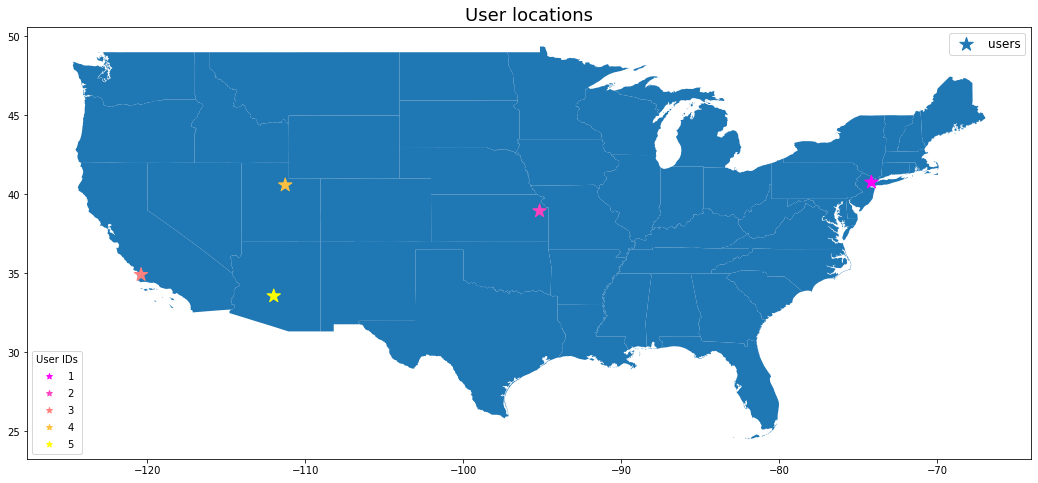

In [23]:
fig, ax = plt.subplots(figsize = (18,16))
usa.plot(ax=ax)

x = tourists_df.X
y = tourists_df.Y
c = tourists_df.USER_ID

scatter = ax.scatter(x, y, c=c, s = 200, marker = '*', cmap = 'spring')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="User IDs")
ax.add_artist(legend1)

legend = ['users']
plt.legend(legend, fontsize = 12)
plt.title('User locations', fontsize = 18)

In [24]:
# Zoom for user 1

#zoom = ['NY', 'PA', 'VT', 'DE', 'RI', 'MA', 'CT', 'NJ', 'ME', 'NH', 'DC']
zoom = ['NY', 'NJ', 'CT']
usa_zoom = usa.set_index('STUSPS').loc[zoom]

Text(0.5, 1, 'Selected museums for user 1')

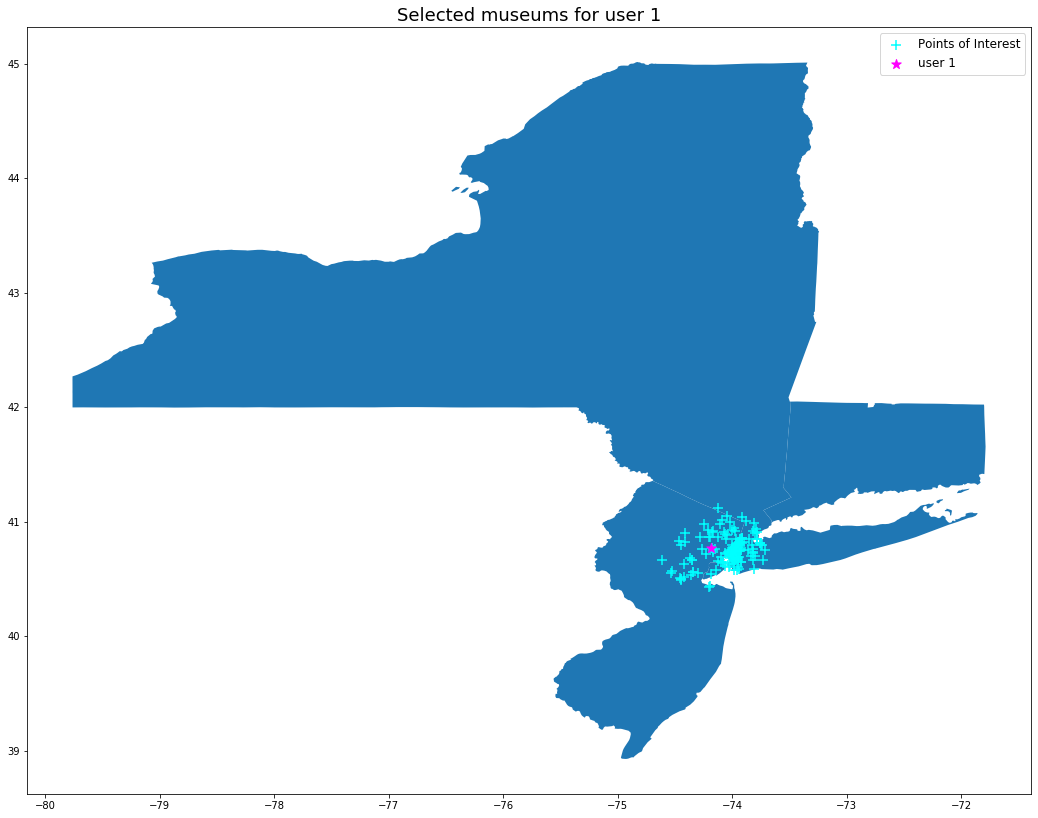

In [25]:
fig, ax = plt.subplots(figsize = (18,16))
usa_zoom.plot(ax=ax)
results_df.plot(ax = ax, marker = '+', markersize = 100, color = 'cyan')

tourists_df.set_index('USER_ID').loc[[userID]].plot(ax = ax, marker = '*', markersize = 100, color = 'magenta')
legend = ['Points of Interest', 'user 1']
plt.legend(legend, fontsize = 12)
plt.title('Selected museums for user 1', fontsize = 18)

___
__Congratulations!__ You reached the end of this notebook. Before shutting Jupyter down, close the current connection to Db2 Warehouse.

In [26]:
idadb.close()
# idadb.reconnect() if connection closed and you want to restore it

Connection closed.


## Where to go from here?

This notebook was a continuation of [Preprocessing](./ibmdbpy_Museums_DataAnalysis_1-preprocessing.ipynb).

If you haven't already done so, we encourage you to have a look at the **Getting started** notebooks also available on this repository. See also the **Machine learning** notebooks.

* Getting started with ibmdbpy:
        
    [Basics](../GettingStarted/ibmdbpy_GettingStarted_1-basics.ipynb)

    [GeoBasics](../GettingStarted/ibmdbpy_GettingStarted_2-geo_basics.ipynb)

    [Extensive Guide](../GettingStarted/ibmdbpy_GettingStarted_3-geo_guide.ipynb)


* Machine learning with ibmdbpy: 
        
    [Naïve Bayes](../MachineLearning/ibmdbpy_NaiveBayes.ipynb)
    
    [Association Rules Mining](../MachineLearning/ibmdbpy_AssociationRulesMining.ipynb)

    [KMeans](../GettingStarted/ibmdbpy_GettingStarted_1-basics.ipynb) 

____

__Authors__

Eva Feillet - ML intern, IBM Cloud and Cognitive Software @ IBM Lab in Böblingen, Germany